<a href="https://colab.research.google.com/github/GayuniMadanayaka/my-project/blob/master/Bigdata_216072F_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .appName("UK_Road_Accidents")
         .getOrCreate())

spark.sparkContext.setLogLevel("WARN")

# Disable Arrow to avoid dtype errors in Colab
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")


In [ ]:
from google.colab import files
files.upload()   # Choose kaggle.json from your computer when asked


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gayunimadanayaka","key":"bf0cc7c89abcb1b64abbe2766e90a386"}'}

In [ ]:
import os
import shutil

# Create the .kaggle directory
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the uploaded kaggle.json into that directory
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set proper permissions
os.chmod("/root/.kaggle/kaggle.json", 0o600)

print("API authentication is now configured!")


API authentication is now configured!


In [ ]:
!kaggle datasets download -d devansodariya/road-accident-united-kingdom-uk-dataset


Dataset URL: https://www.kaggle.com/datasets/devansodariya/road-accident-united-kingdom-uk-dataset
License(s): CC0-1.0
  0% 0.00/56.8M [00:00<?, ?B/s]
100% 56.8M/56.8M [00:00<00:00, 754MB/s]


In [ ]:
!unzip road-accident-united-kingdom-uk-dataset.zip -d road_accident_data/


Archive:  road-accident-united-kingdom-uk-dataset.zip
  inflating: road_accident_data/UK_Accident.csv  


In [ ]:
!ls road_accident_data/


UK_Accident.csv


In [ ]:
# Load CSV into Spark DataFrame using the correct filename
df_spark = spark.read.csv("road_accident_data/UK_Accident.csv", header=True, inferSchema=True)

# Show first few rows
df_spark.show(5)

# Check schema
df_spark.printSchema()

# Check row count
print("Number of rows:", df_spark.count())


+---+--------------+---------------------+----------------------+---------+---------+------------+-----------------+------------------+--------------------+----------+-----------+-------------------+--------------------------+-------------------------+--------------+---------------+------------------+-----------+--------------------+--------------+---------------+---------------------------------+---------------------------------------+--------------------+--------------------+-----------------------+--------------------------+-------------------+-------------------+-------------------------------------------+-------------------------+----+
|_c0|Accident_Index|Location_Easting_OSGR|Location_Northing_OSGR|Longitude| Latitude|Police_Force|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|      Date|Day_of_Week|               Time|Local_Authority_(District)|Local_Authority_(Highway)|1st_Road_Class|1st_Road_Number|         Road_Type|Speed_limit|    Junction_Control|2nd_Road_Class|2

#### Missing values


In [ ]:
# Count missing values per column
from pyspark.sql.functions import col, isnan, when, count
missing_counts = df_spark.select([count(when(col(c).isNull(), c)).alias(c) for c in df_spark.columns])
missing_counts.show()



+---+--------------+---------------------+----------------------+---------+--------+------------+-----------------+------------------+--------------------+----+-----------+----+--------------------------+-------------------------+--------------+---------------+---------+-----------+----------------+--------------+---------------+---------------------------------+---------------------------------------+----------------+------------------+-----------------------+--------------------------+-------------------+-------------------+-------------------------------------------+-------------------------+----+
|_c0|Accident_Index|Location_Easting_OSGR|Location_Northing_OSGR|Longitude|Latitude|Police_Force|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|Date|Day_of_Week|Time|Local_Authority_(District)|Local_Authority_(Highway)|1st_Road_Class|1st_Road_Number|Road_Type|Speed_limit|Junction_Control|2nd_Road_Class|2nd_Road_Number|Pedestrian_Crossing-Human_Control|Pedestrian_Crossing-Physica

#### Duplicates


In [ ]:
total_rows = df_spark.count()
distinct_rows = df_spark.distinct().count()
duplicate_rows = total_rows - distinct_rows

print(f"Total rows: {total_rows}")
print(f"Distinct rows: {distinct_rows}")
print(f"Duplicate rows: {duplicate_rows}")


Total rows: 1504150
Distinct rows: 1504150
Duplicate rows: 0


In [ ]:
#data cleaning
#Trim string columns
from pyspark.sql.functions import trim

for c, t in df_spark.dtypes:
    if t == 'string':
        df_spark = df_spark.withColumn(c, trim(col(c)))



#Parse Date and clean Time
from pyspark.sql.functions import to_date, when, length

df_spark = df_spark.withColumn("Date_parsed", to_date(col("Date"), "dd/MM/yyyy"))

df_spark = df_spark.withColumn(
    "Time_clean",
    when(col("Time").isNull() | (length(col("Time")) < 4), None)
    .otherwise(col("Time"))
)



#Handle missing Year
from pyspark.sql.functions import year

df_spark = df_spark.withColumn(
    "Year",
    when(col("Year").isNull(), year(col("Date_parsed")))
    .otherwise(col("Year"))
)




In [ ]:
#Persist cleaned data as Parquet
parquet_dir = "road_accident_data/UK_Accident_parquet"

(df_spark.repartition("Year")
         .write.mode("overwrite")
         .partitionBy("Year")
         .parquet(parquet_dir))

# Reload as cached DataFrame for analysis
acc = spark.read.parquet(parquet_dir)
acc.cache()

print("Rows after loading parquet:", acc.count())
acc.printSchema()


Rows after loading parquet: 1504150
root
 |-- _c0: integer (nullable = true)
 |-- Accident_Index: string (nullable = true)
 |-- Location_Easting_OSGR: double (nullable = true)
 |-- Location_Northing_OSGR: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Police_Force: integer (nullable = true)
 |-- Accident_Severity: integer (nullable = true)
 |-- Number_of_Vehicles: integer (nullable = true)
 |-- Number_of_Casualties: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Local_Authority_(District): integer (nullable = true)
 |-- Local_Authority_(Highway): string (nullable = true)
 |-- 1st_Road_Class: integer (nullable = true)
 |-- 1st_Road_Number: integer (nullable = true)
 |-- Road_Type: string (nullable = true)
 |-- Speed_limit: integer (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- 2nd_Road_Class: intege

In [ ]:
#Info-style summary (non-null + dtype)


non_null_counts = acc.select([count(when(col(c).isNotNull(), c)).alias(c) for c in acc.columns]).collect()[0]

null_counts = {col_name: acc.count() - non_null_counts[i] for i, col_name in enumerate(acc.columns)}

print("\nInfo Summary:")
for i, (col_name, dtype) in enumerate(acc.dtypes):
    non_null = non_null_counts[i]
    null_val = null_counts[col_name]
    print(f"{col_name} ({dtype}) -> Non-Null: {non_null}, Null: {null_val}")



Info Summary:
_c0 (int) -> Non-Null: 1504150, Null: 0
Accident_Index (string) -> Non-Null: 1504150, Null: 0
Location_Easting_OSGR (double) -> Non-Null: 1504049, Null: 101
Location_Northing_OSGR (double) -> Non-Null: 1504150, Null: 0
Longitude (double) -> Non-Null: 1504049, Null: 101
Latitude (double) -> Non-Null: 1504150, Null: 0
Police_Force (int) -> Non-Null: 1504150, Null: 0
Accident_Severity (int) -> Non-Null: 1504150, Null: 0
Number_of_Vehicles (int) -> Non-Null: 1504150, Null: 0
Number_of_Casualties (int) -> Non-Null: 1504150, Null: 0
Date (string) -> Non-Null: 1504150, Null: 0
Day_of_Week (int) -> Non-Null: 1504150, Null: 0
Time (timestamp) -> Non-Null: 1504033, Null: 117
Local_Authority_(District) (int) -> Non-Null: 1504150, Null: 0
Local_Authority_(Highway) (string) -> Non-Null: 1504150, Null: 0
1st_Road_Class (int) -> Non-Null: 1504150, Null: 0
1st_Road_Number (int) -> Non-Null: 1504150, Null: 0
Road_Type (string) -> Non-Null: 1504150, Null: 0
Speed_limit (int) -> Non-Null: 

#### Handle missing values

In [ ]:
from pyspark.sql.functions import col

# 1. Drop rows where critical location is missing
acc = acc.dropna(subset=["Location_Easting_OSGR", "Longitude"])

# 2. Drop rows where Time is missing (tiny fraction)
acc = acc.dropna(subset=["Time"])

# 3. Fill categorical with mode
categorical_cols = [
    "Pedestrian_Crossing-Human_Control",
    "Pedestrian_Crossing-Physical_Facilities"
]

for c in categorical_cols:
    mode_val = acc.groupBy(c).count().orderBy("count", ascending=False).first()[0]
    acc = acc.fillna({c: mode_val})

# 4. Fill LSOA with "Unknown"
acc = acc.fillna({"LSOA_of_Accident_Location": "Unknown"})



## EDA



## Summary statistics


In [ ]:
# Descriptive statistics for numeric columns
numeric_cols = [
    "Location_Easting_OSGR", "Location_Northing_OSGR", "Longitude", "Latitude",
    "Number_of_Vehicles", "Number_of_Casualties", "Speed_limit", "Accident_Severity"
]

acc.select(numeric_cols).describe().show()


+-------+---------------------+----------------------+-------------------+------------------+------------------+--------------------+------------------+------------------+
|summary|Location_Easting_OSGR|Location_Northing_OSGR|          Longitude|          Latitude|Number_of_Vehicles|Number_of_Casualties|       Speed_limit| Accident_Severity|
+-------+---------------------+----------------------+-------------------+------------------+------------------+--------------------+------------------+------------------+
|  count|              1503932|               1503932|            1503932|           1503932|           1503932|             1503932|           1503932|           1503932|
|   mean|    439626.3163992787|     300129.1249770601|-1.4365486449799867| 52.58913619013124|1.8316200466510455|  1.3509766399012721|39.004562706292575|2.8381921523047584|
| stddev|    95115.25039794415|    160970.70206202532| 1.3980568204066173|1.4495501017601644|0.7147636023321088|  0.8253596651503797|14.1395

In [ ]:
from pyspark.sql.functions import col, expr

numeric_cols = ["Location_Easting_OSGR", "Location_Northing_OSGR", "Longitude", "Latitude",
                "Number_of_Vehicles", "Number_of_Casualties", "Speed_limit", "Accident_Severity"]

# Quartiles (25%, 50%, 75%)
for c in numeric_cols:
    quantiles = acc.approxQuantile(c, [0.25, 0.5, 0.75], 0.01)
    print(f"{c} - 25%: {quantiles[0]}, Median: {quantiles[1]}, 75%: {quantiles[2]}")

# Variance
for c in numeric_cols:
    acc.select(expr(f"variance({c})").alias(c)).show()

# Skewness and Kurtosis
from pyspark.sql.functions import skewness, kurtosis
acc.select([skewness(c).alias(c) for c in numeric_cols]).show()
acc.select([kurtosis(c).alias(c) for c in numeric_cols]).show()


Location_Easting_OSGR - 25%: 372410.0, Median: 439210.0, 75%: 522440.0
Location_Northing_OSGR - 25%: 177940.0, Median: 266370.0, 75%: 398140.0
Longitude - 25%: -2.369786, Median: -1.409197, 75%: -0.222509
Latitude - 25%: 51.485597, Median: 52.294781, 75%: 53.478117
Number_of_Vehicles - 25%: 1.0, Median: 2.0, 75%: 2.0
Number_of_Casualties - 25%: 1.0, Median: 1.0, 75%: 1.0
Speed_limit - 25%: 30.0, Median: 30.0, 75%: 50.0
Accident_Severity - 25%: 3.0, Median: 3.0, 75%: 3.0
+---------------------+
|Location_Easting_OSGR|
+---------------------+
|  9.046910858263617E9|
+---------------------+

+----------------------+
|Location_Northing_OSGR|
+----------------------+
|  2.591156692234132E10|
+----------------------+

+------------------+
|         Longitude|
+------------------+
|1.9545628730854607|
+------------------+

+-----------------+
|         Latitude|
+-----------------+
|2.101195497512903|
+-----------------+

+------------------+
|Number_of_Vehicles|
+------------------+
| 0.5108

In [ ]:
categorical_cols = ["Road_Type", "Weather_Conditions", "Light_Conditions", "Junction_Control",
                    "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities"]

total_count = acc.count()

for c in categorical_cols:
    acc.groupBy(c).count() \
       .withColumn("percentage", (col("count")/total_count)*100) \
       .orderBy("count", ascending=False).show()


+------------------+-------+------------------+
|         Road_Type|  count|        percentage|
+------------------+-------+------------------+
|Single carriageway|1126781|   74.922336914169|
|  Dual carriageway| 221717|14.742488357186362|
|        Roundabout| 100453| 6.679357843306745|
|    One way street|  30977|  2.05973408372187|
|         Slip road|  15667|1.0417359295500064|
|           Unknown|   8337|0.5543468720660243|
+------------------+-------+------------------+

+--------------------+-------+-------------------+
|  Weather_Conditions|  count|         percentage|
+--------------------+-------+-------------------+
|Fine without high...|1203781|  80.04224925063102|
|Raining without h...| 177638| 11.811571267849876|
|               Other|  33496| 2.2272283587289854|
|             Unknown|  28406| 1.8887822055784438|
|Raining with high...|  20811| 1.3837726705728717|
|Fine with high winds|  18353|  1.220334430014123|
|Snowing without h...|  11301|  0.751430250835809|
|        

In [ ]:
# Example: Weather vs Severity
acc.groupBy("Weather_Conditions", "Accident_Severity").count().orderBy("Weather_Conditions", "Accident_Severity").show()

# Example: Road_Type vs Severity
acc.groupBy("Road_Type", "Accident_Severity").count().orderBy("Road_Type", "Accident_Severity").show()


+--------------------+-----------------+-------+
|  Weather_Conditions|Accident_Severity|  count|
+--------------------+-----------------+-------+
|Fine with high winds|                1|    339|
|Fine with high winds|                2|   2688|
|Fine with high winds|                3|  15326|
|Fine without high...|                1|  16144|
|Fine without high...|                2| 168750|
|Fine without high...|                3|1018887|
|         Fog or mist|                1|    179|
|         Fog or mist|                2|   1147|
|         Fog or mist|                3|   6861|
|               Other|                1|    294|
|               Other|                2|   3677|
|               Other|                3|  29525|
|Raining with high...|                1|    280|
|Raining with high...|                2|   2769|
|Raining with high...|                3|  17762|
|Raining without h...|                1|   1854|
|Raining without h...|                2|  21440|
|Raining without h..

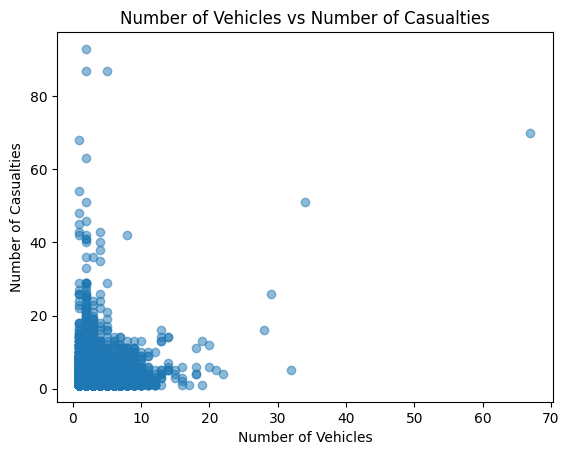

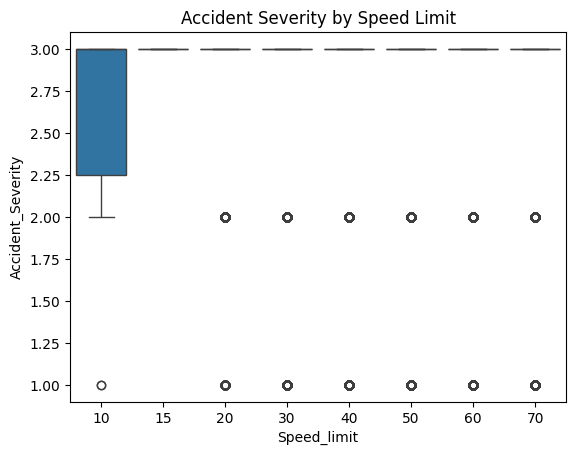

In [ ]:
# Vehicles vs Casualties
import matplotlib.pyplot as plt  # Make sure this is included

num_pd = acc.select("Number_of_Vehicles", "Number_of_Casualties").toPandas()
plt.scatter(num_pd["Number_of_Vehicles"], num_pd["Number_of_Casualties"], alpha=0.5)
plt.xlabel("Number of Vehicles")
plt.ylabel("Number of Casualties")
plt.title("Number of Vehicles vs Number of Casualties")
plt.show()


# Speed Limit vs Severity (Boxplot)
import seaborn as sns
speed_severity_pd = acc.select("Speed_limit", "Accident_Severity").toPandas()
sns.boxplot(x="Speed_limit", y="Accident_Severity", data=speed_severity_pd)
plt.title("Accident Severity by Speed Limit")
plt.show()


## Visualizations


### Patterns

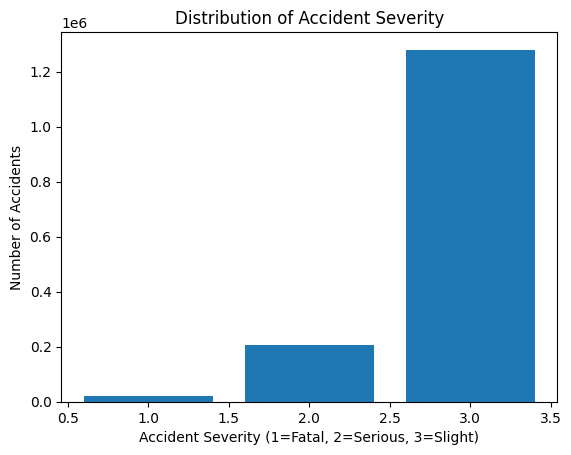

In [ ]:

#Accident Severity Distribution

import matplotlib.pyplot as plt

# Convert to pandas for plotting
severity_pd = acc.groupBy("Accident_Severity").count().toPandas()

plt.bar(severity_pd["Accident_Severity"], severity_pd["count"])
plt.xlabel("Accident Severity (1=Fatal, 2=Serious, 3=Slight)")
plt.ylabel("Number of Accidents")
plt.title("Distribution of Accident Severity")
plt.show()


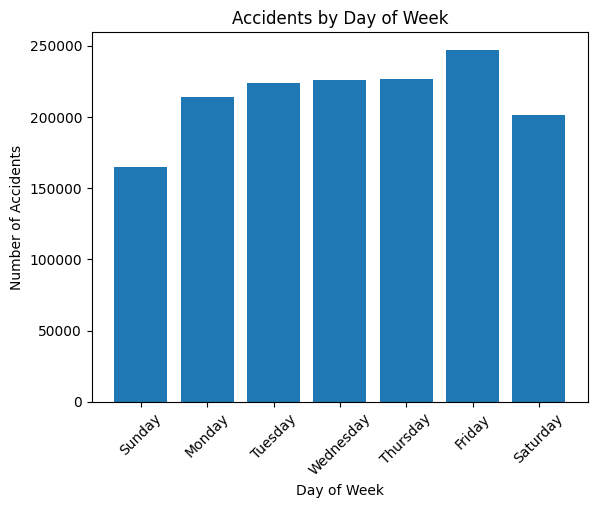

In [ ]:
#Accidents by Day of Week

day_map = {
    1: "Sunday", 2: "Monday", 3: "Tuesday",
    4: "Wednesday", 5: "Thursday", 6: "Friday", 7: "Saturday"
}

day_pd = acc.groupBy("Day_of_Week").count().orderBy("Day_of_Week").toPandas()
day_pd["Day_of_Week"] = day_pd["Day_of_Week"].map(day_map)

plt.bar(day_pd["Day_of_Week"], day_pd["count"])
plt.xticks(rotation=45)
plt.xlabel("Day of Week")
plt.ylabel("Number of Accidents")
plt.title("Accidents by Day of Week")
plt.show()


+------------------+-------+
|         Road_Type|  count|
+------------------+-------+
|Single carriageway|1126781|
|  Dual carriageway| 221717|
|        Roundabout| 100453|
|    One way street|  30977|
|         Slip road|  15667|
|           Unknown|   8337|
+------------------+-------+



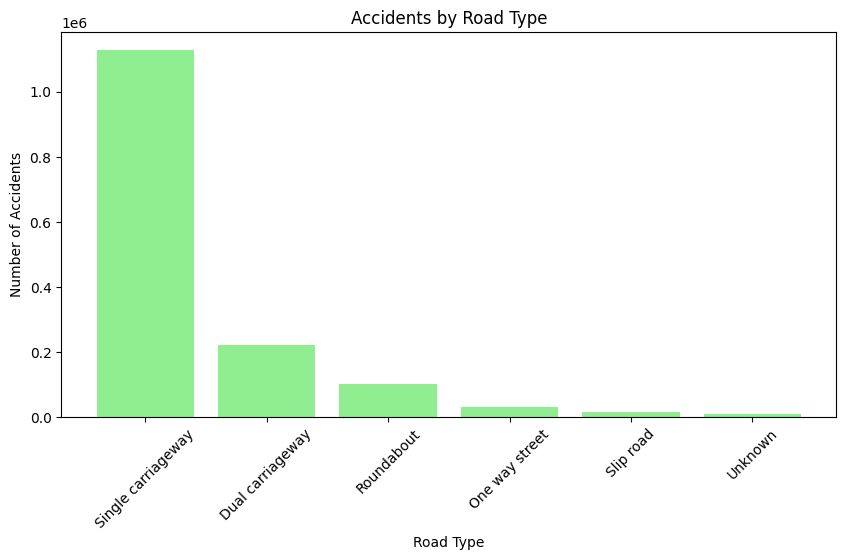

In [ ]:
road_counts = acc.groupBy("Road_Type").count().orderBy("count", ascending=False)
road_counts.show(10)  # Top 10 road types

# Visualization
road_counts_pd = road_counts.toPandas()
plt.figure(figsize=(10,5))
plt.bar(road_counts_pd['Road_Type'], road_counts_pd['count'], color='lightgreen')
plt.xticks(rotation=45)
plt.xlabel("Road Type")
plt.ylabel("Number of Accidents")
plt.title("Accidents by Road Type")
plt.show()


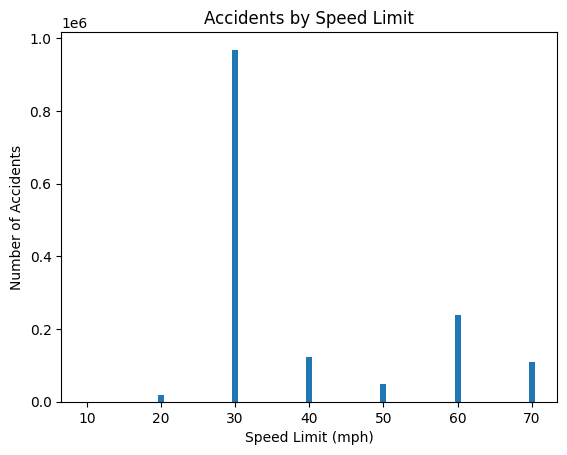

In [ ]:
#Accidents by Speed Limit

speed_pd = acc.groupBy("Speed_limit").count().orderBy("Speed_limit").toPandas()

plt.bar(speed_pd["Speed_limit"], speed_pd["count"])
plt.xlabel("Speed Limit (mph)")
plt.ylabel("Number of Accidents")
plt.title("Accidents by Speed Limit")
plt.show()


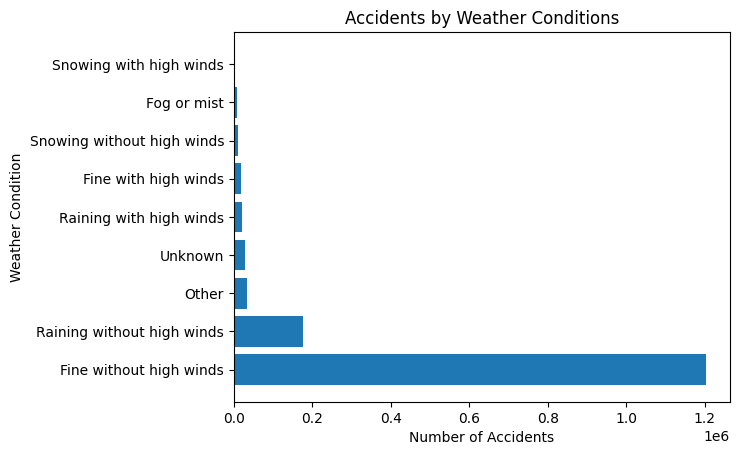

In [ ]:
#Weather Conditions vs Accidents

weather_pd = acc.groupBy("Weather_Conditions").count().orderBy("count", ascending=False).toPandas()

plt.barh(weather_pd["Weather_Conditions"], weather_pd["count"])
plt.xlabel("Number of Accidents")
plt.ylabel("Weather Condition")
plt.title("Accidents by Weather Conditions")
plt.show()


#### Trends (Temporal Patterns)

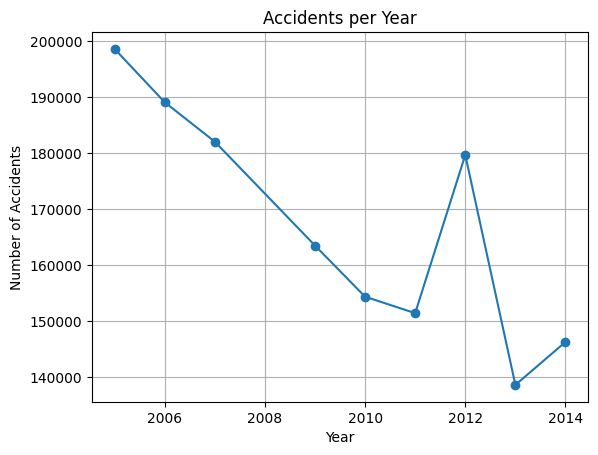

In [ ]:
# Accidents by Year

yearly_pd = acc.groupBy("Year").count().orderBy("Year").toPandas()

plt.plot(yearly_pd["Year"], yearly_pd["count"], marker="o")
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.title("Accidents per Year")
plt.grid(True)
plt.show()


+----+------+
|Hour| count|
+----+------+
|   0| 23025|
|   1| 16888|
|   2| 13618|
|   3| 10826|
|   4|  8347|
|   5| 12035|
|   6| 25831|
|   7| 62369|
|   8|109617|
|   9| 74898|
|  10| 67891|
|  11| 78132|
|  12| 89217|
|  13| 91351|
|  14| 91253|
|  15|116261|
|  16|122122|
|  17|133728|
|  18|104078|
|  19| 77722|
+----+------+
only showing top 20 rows



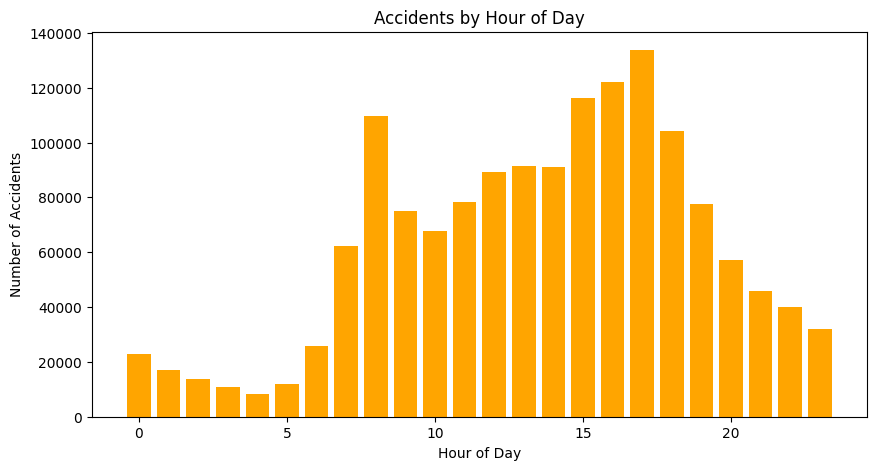

In [ ]:
from pyspark.sql.functions import hour

# Extract hour from Time_clean
acc_hour = acc.withColumn("Hour", hour(col("Time_clean")))

hour_counts = acc_hour.groupBy("Hour").count().orderBy("Hour")
hour_counts.show()

# Visualization
hour_counts_pd = hour_counts.toPandas()
plt.figure(figsize=(10,5))
plt.bar(hour_counts_pd['Hour'], hour_counts_pd['count'], color='orange')
plt.xlabel("Hour of Day")
plt.ylabel("Number of Accidents")
plt.title("Accidents by Hour of Day")
plt.show()


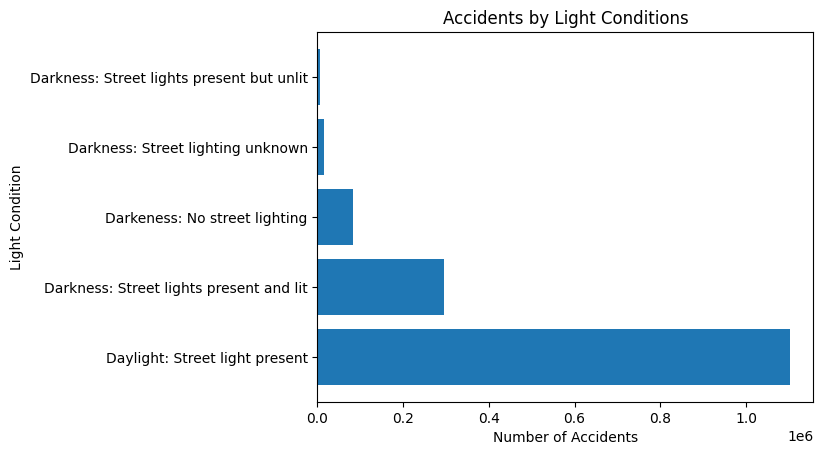

In [ ]:
#Light Conditions vs Accidents(Checks whether most crashes occur in daylight/night.)

light_pd = acc.groupBy("Light_Conditions").count().orderBy("count", ascending=False).toPandas()

plt.barh(light_pd["Light_Conditions"], light_pd["count"])
plt.xlabel("Number of Accidents")
plt.ylabel("Light Condition")
plt.title("Accidents by Light Conditions")
plt.show()


In [ ]:
from pyspark.sql.functions import variance

for col_name in numeric_cols:
    acc.select(variance(col_name).alias(col_name)).show()


+---------------------+
|Location_Easting_OSGR|
+---------------------+
|  9.046910858263617E9|
+---------------------+

+----------------------+
|Location_Northing_OSGR|
+----------------------+
|  2.591156692234132E10|
+----------------------+

+------------------+
|         Longitude|
+------------------+
|1.9545628730854607|
+------------------+

+-----------------+
|         Latitude|
+-----------------+
|2.101195497512903|
+-----------------+

+------------------+
|Number_of_Vehicles|
+------------------+
| 0.510887007218773|
+------------------+

+--------------------+
|Number_of_Casualties|
+--------------------+
|   0.681218576857147|
+--------------------+

+------------------+
|       Speed_limit|
+------------------+
|199.92566859164702|
+------------------+

+-------------------+
|  Accident_Severity|
+-------------------+
|0.16147840817102685|
+-------------------+



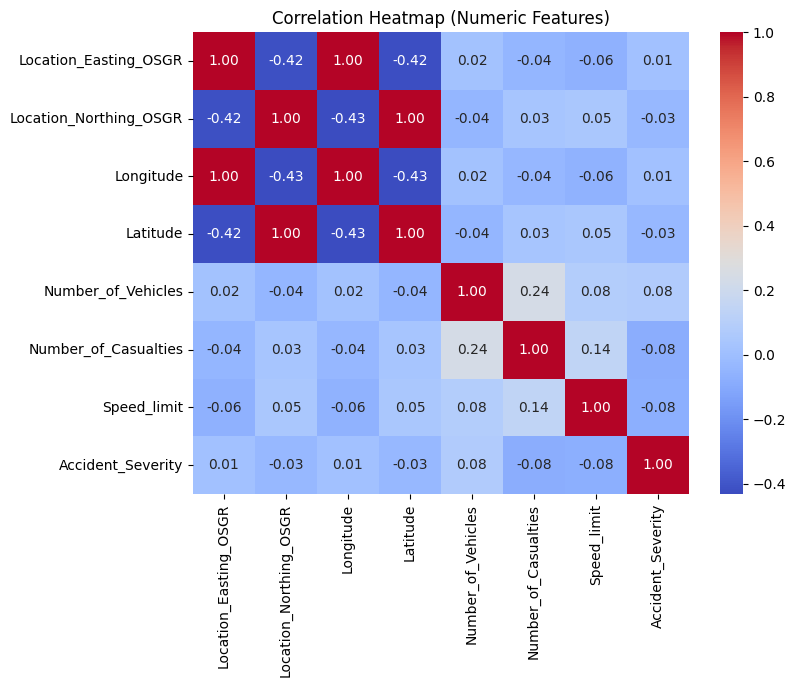

In [ ]:
#Correlation Heatmap (Numerical Features)

import seaborn as sns

# Convert to pandas
num_pd = acc.select(numeric_cols).toPandas()

plt.figure(figsize=(8,6))
sns.heatmap(num_pd.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


In [ ]:
# Drop duplicate location variables
acc = acc.drop("Location_Easting_OSGR", "Location_Northing_OSGR")

# Check remaining columns
acc.printSchema()


root
 |-- _c0: integer (nullable = true)
 |-- Accident_Index: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Police_Force: integer (nullable = true)
 |-- Accident_Severity: integer (nullable = true)
 |-- Number_of_Vehicles: integer (nullable = true)
 |-- Number_of_Casualties: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Local_Authority_(District): integer (nullable = true)
 |-- Local_Authority_(Highway): string (nullable = true)
 |-- 1st_Road_Class: integer (nullable = true)
 |-- 1st_Road_Number: integer (nullable = true)
 |-- Road_Type: string (nullable = true)
 |-- Speed_limit: integer (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- 2nd_Road_Class: integer (nullable = true)
 |-- 2nd_Road_Number: integer (nullable = true)
 |-- Pedestrian_Crossing-Human_Control: string (nullable = false)
 |-- Pede

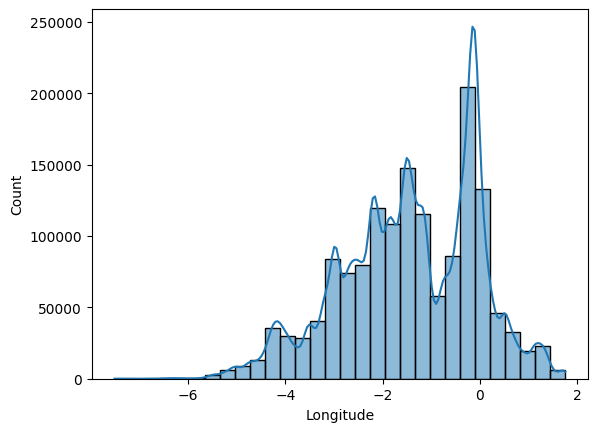

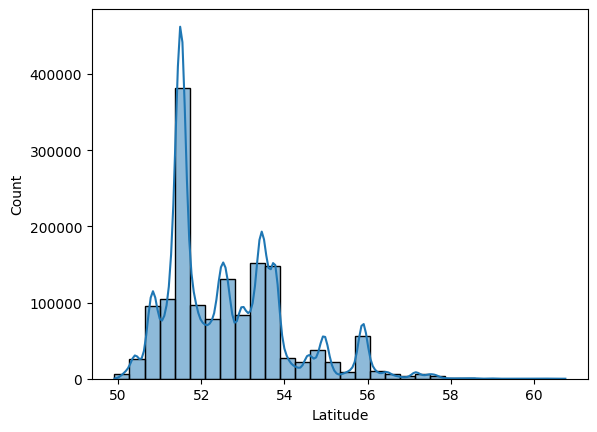

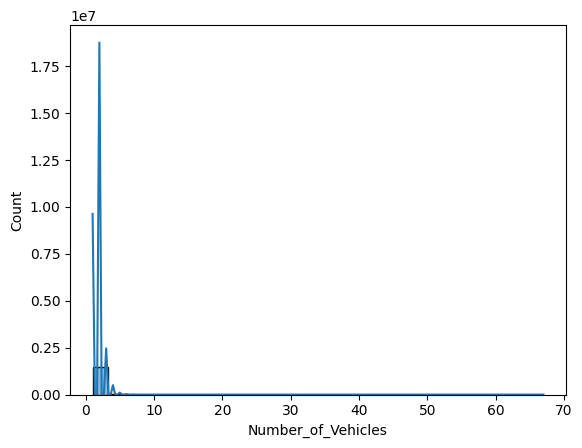

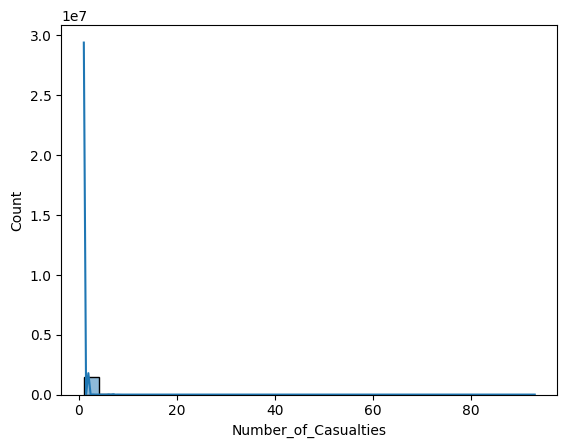

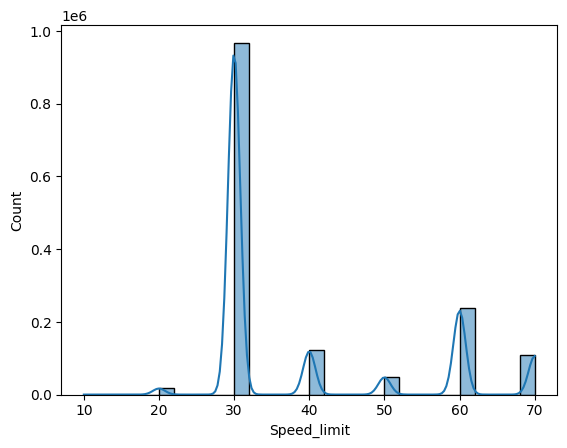

In [ ]:
numeric_cols = ["Longitude", "Latitude", "Number_of_Vehicles", "Number_of_Casualties", "Speed_limit"]

for col_name in numeric_cols:
    col_pd = acc.select(col_name).toPandas()  # single column at a time
    sns.histplot(col_pd[col_name], bins=30, kde=True)
    plt.show()


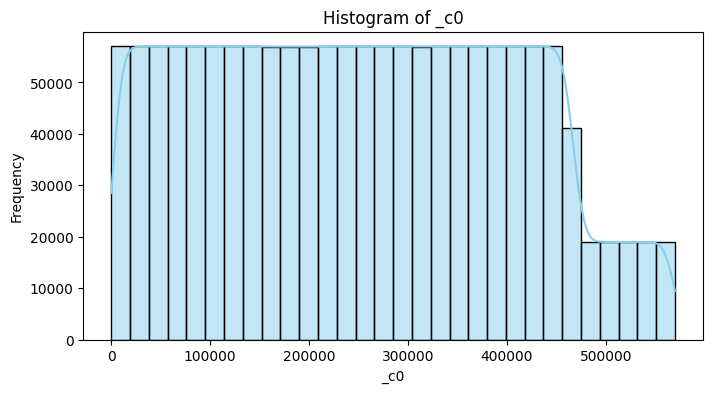

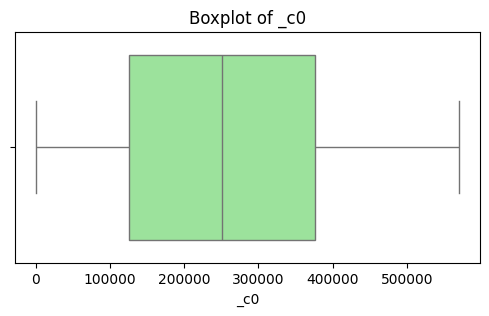

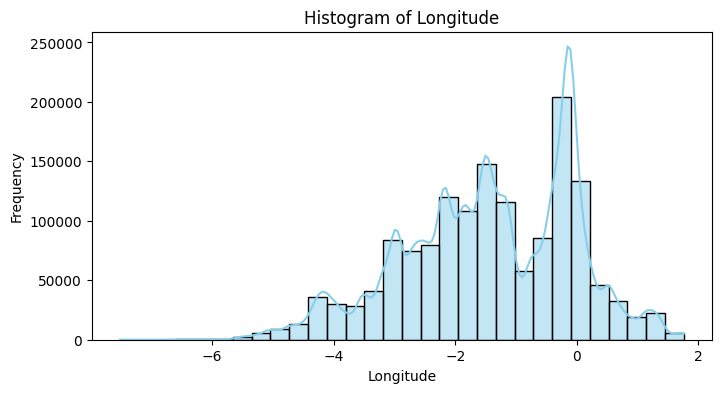

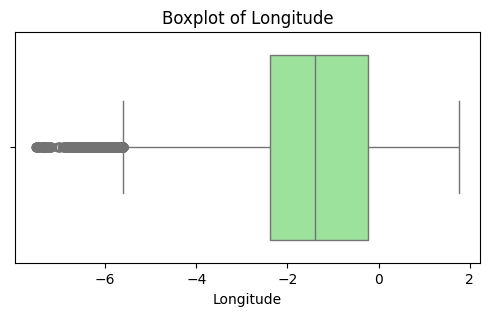

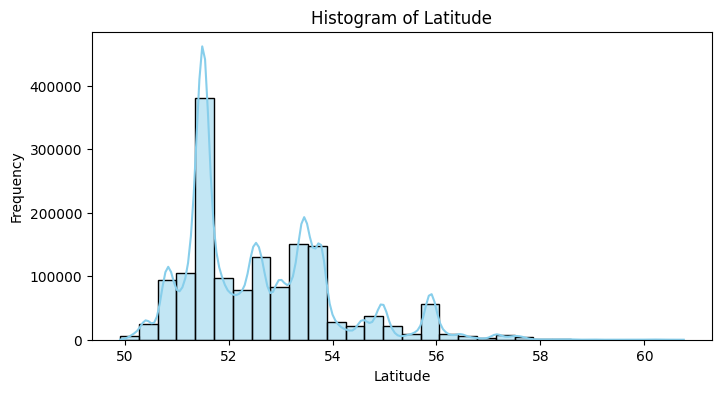

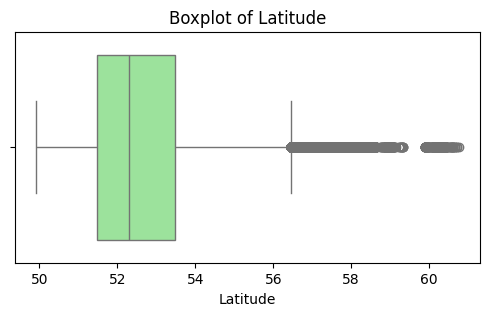

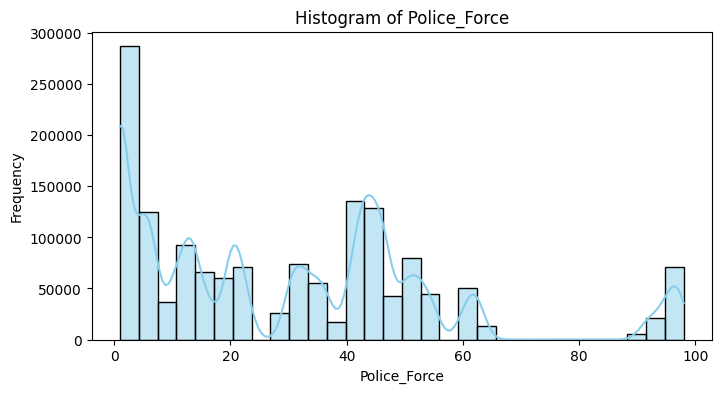

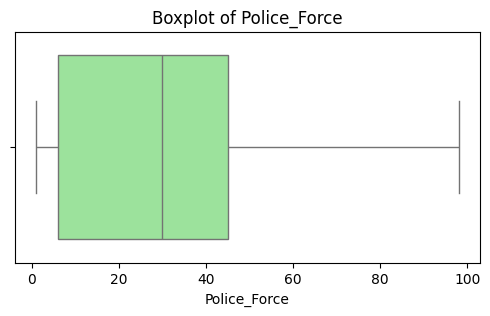

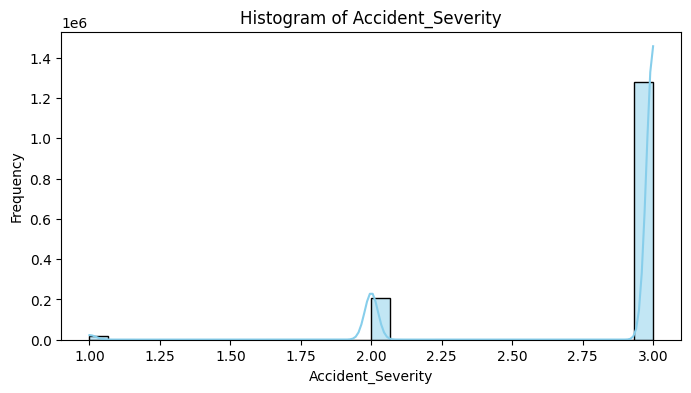

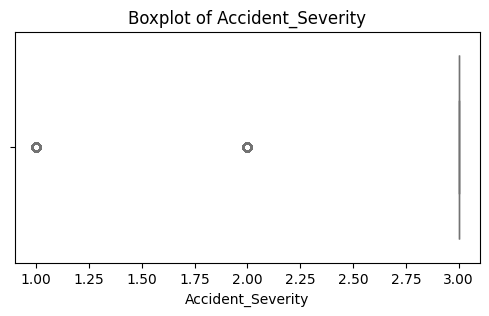

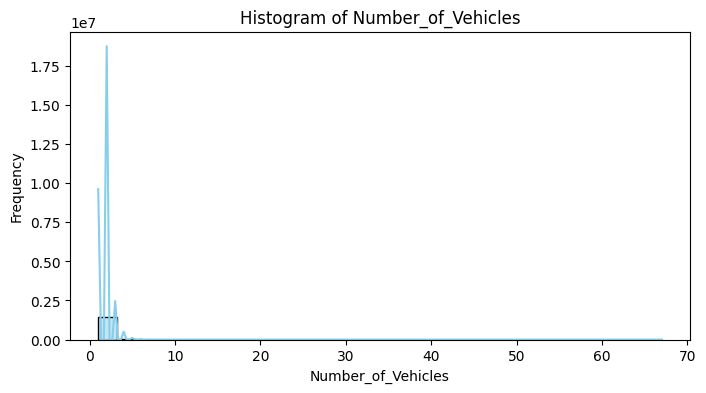

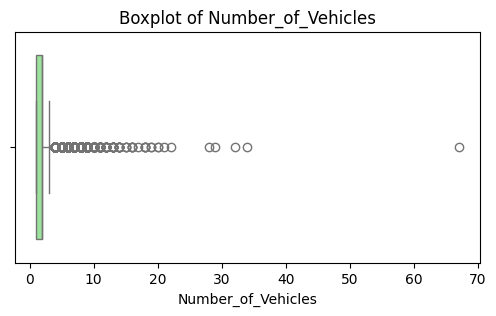

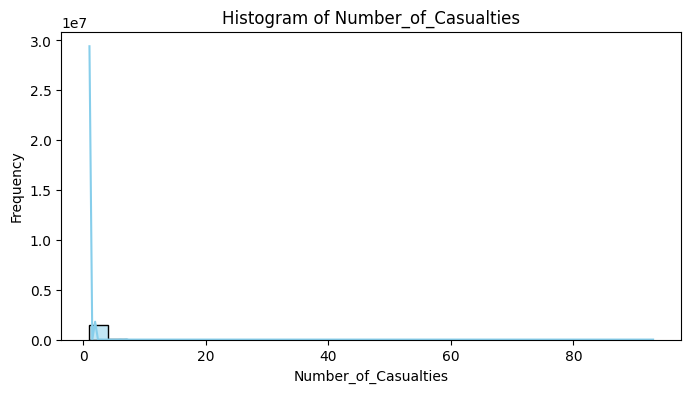

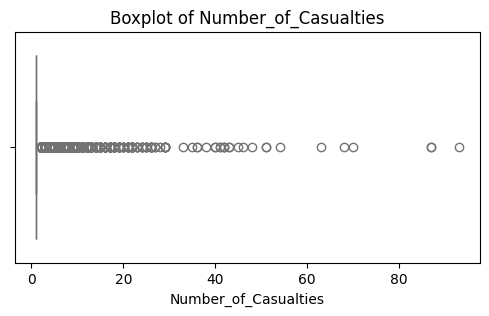

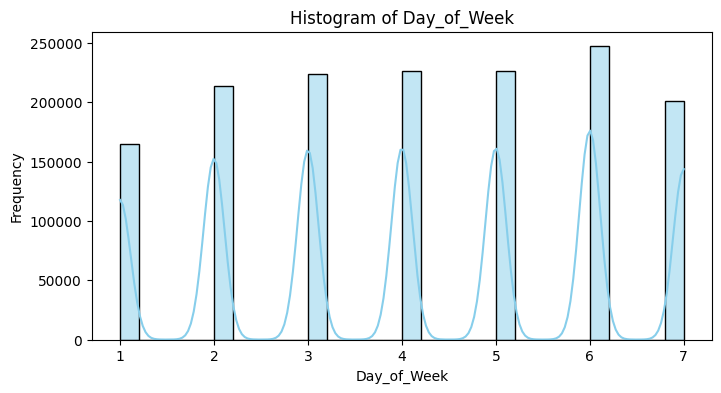

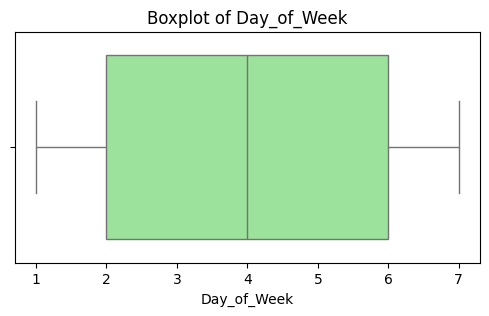

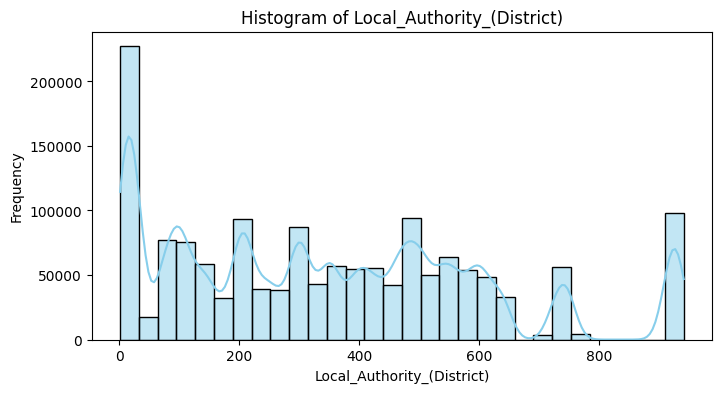

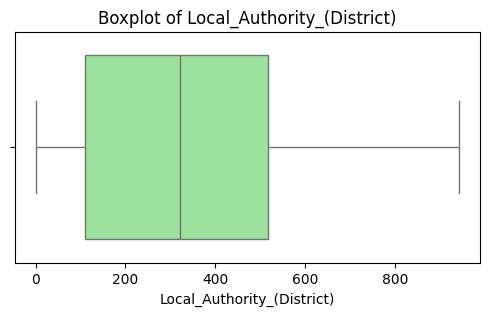

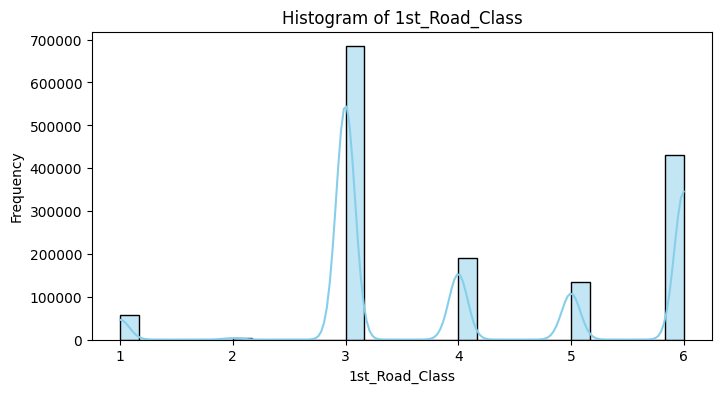

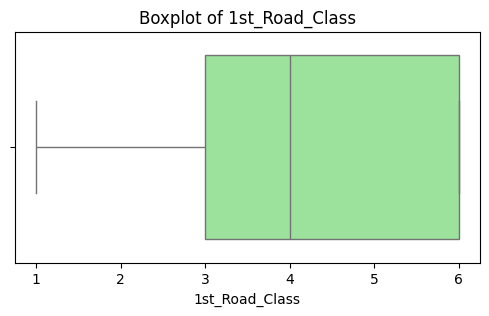

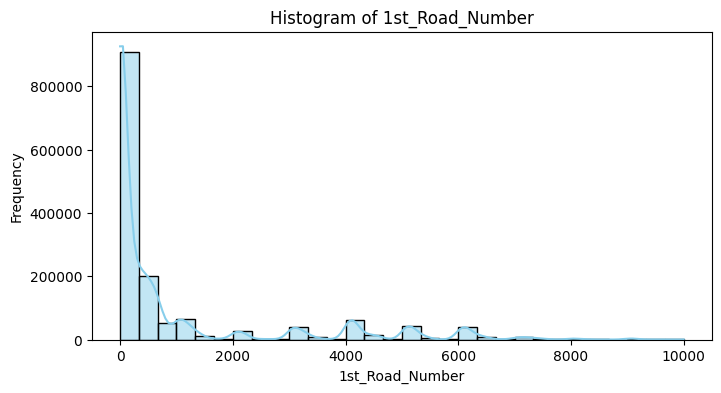

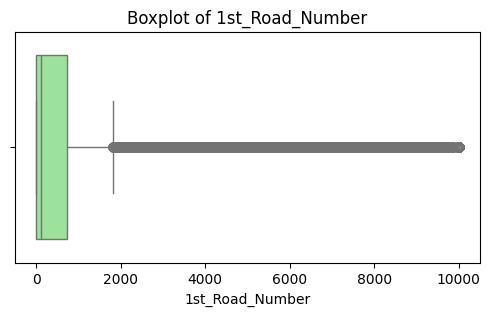

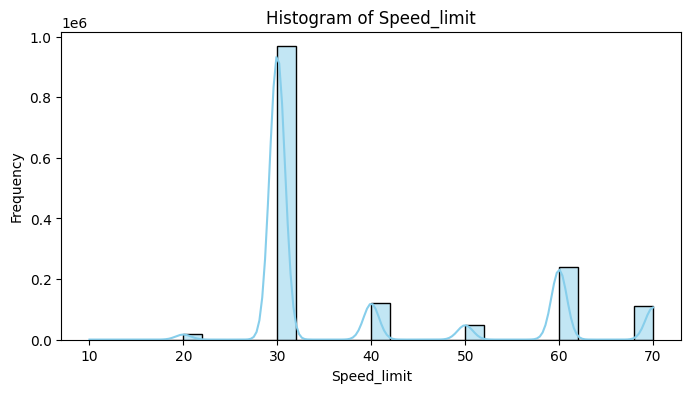

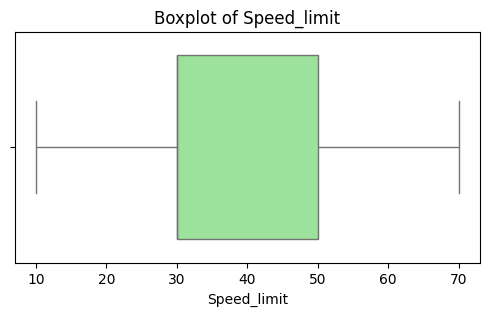

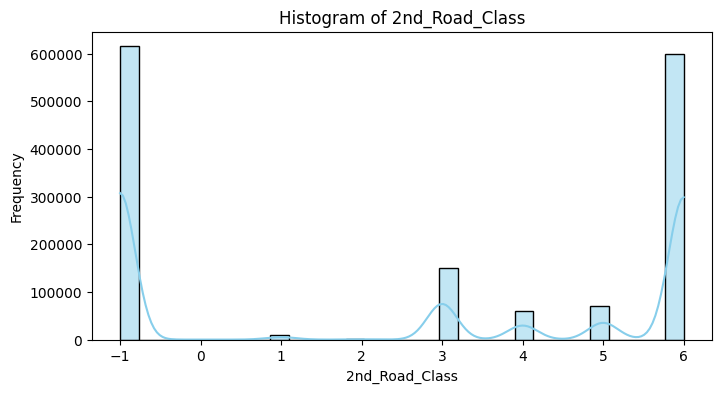

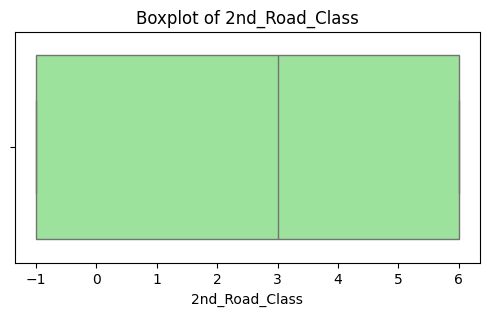

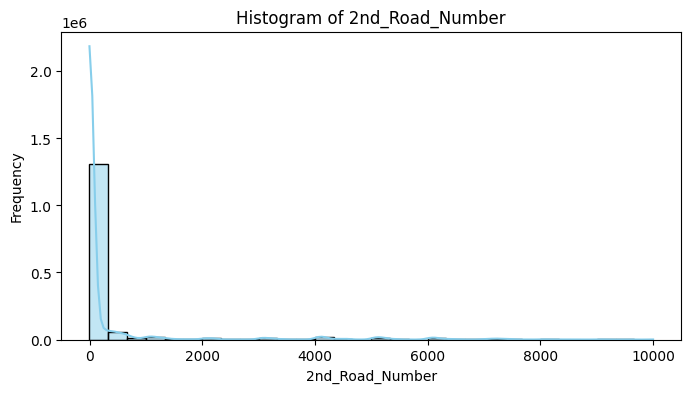

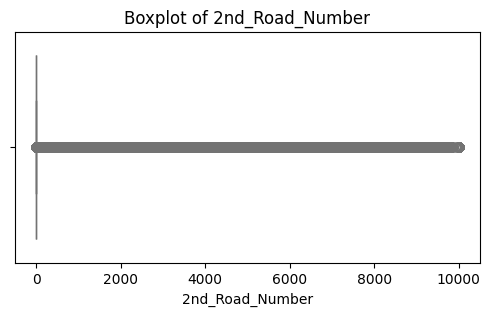

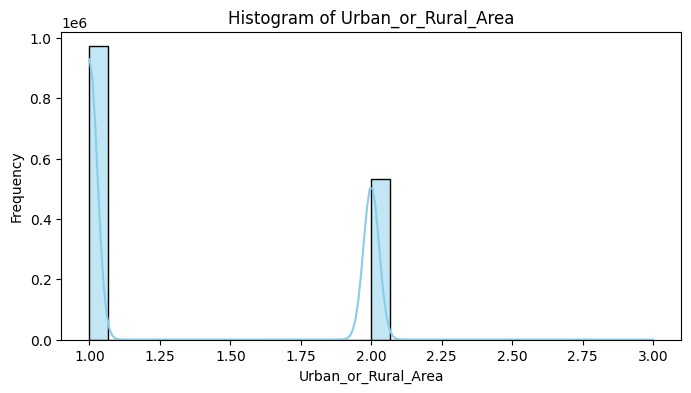

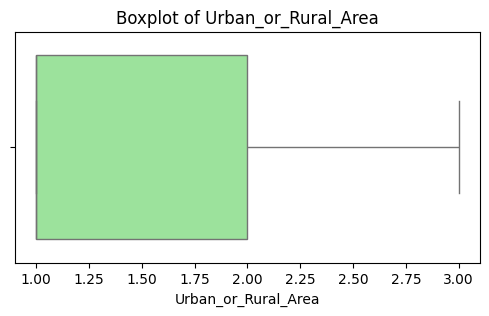

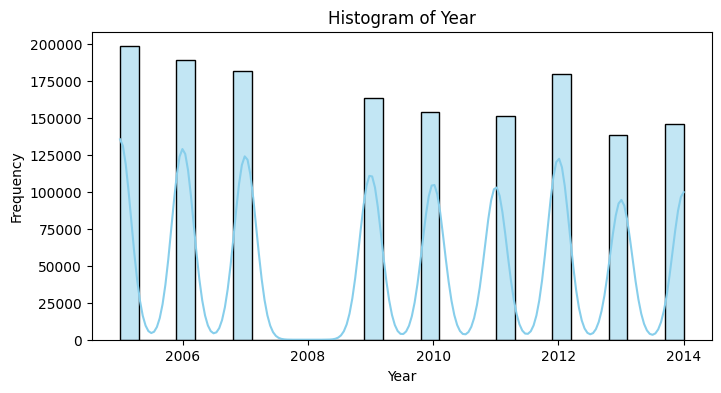

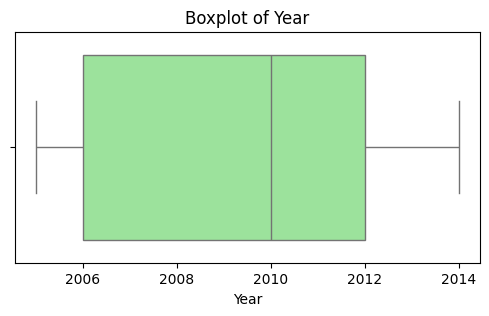

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, DoubleType

# Ensure all numeric columns are correctly typed
numeric_cols = [
    "_c0","Longitude", "Latitude",
    "Police_Force", "Accident_Severity", "Number_of_Vehicles", "Number_of_Casualties",
    "Day_of_Week", "Local_Authority_(District)", "1st_Road_Class", "1st_Road_Number",
    "Speed_limit", "2nd_Road_Class", "2nd_Road_Number", "Urban_or_Rural_Area", "Year"
]

# Cast to appropriate numeric types
for c in numeric_cols:
    acc = acc.withColumn(c, col(c).cast(DoubleType()))

# Plot histograms and boxplots one column at a time
for c in numeric_cols:
    # Convert only the current column to Pandas
    col_pd = acc.select(c).toPandas()

    # Histogram
    plt.figure(figsize=(8,4))
    sns.histplot(col_pd[c], bins=30, kde=True, color='skyblue')
    plt.title(f"Histogram of {c}")
    plt.xlabel(c)
    plt.ylabel("Frequency")
    plt.show()

    # Boxplot
    plt.figure(figsize=(6,3))
    sns.boxplot(x=col_pd[c], color='lightgreen')
    plt.title(f"Boxplot of {c}")
    plt.show()


In [ ]:
from pyspark.sql import functions as F

def cap_outliers(df, column, lower_percentile=0.05, upper_percentile=0.95):
    # Get the quantiles
    quantiles = df.approxQuantile(column, [lower_percentile, upper_percentile], 0.05)
    lower_bound, upper_bound = quantiles[0], quantiles[1]

    # Apply capping
    df = df.withColumn(
        column,
        F.when(F.col(column) < lower_bound, lower_bound)
         .when(F.col(column) > upper_bound, upper_bound)
         .otherwise(F.col(column))
    )
    return df


In [ ]:
for c in numeric_cols:
    acc = cap_outliers(acc, c, lower_percentile=0.05, upper_percentile=0.95)


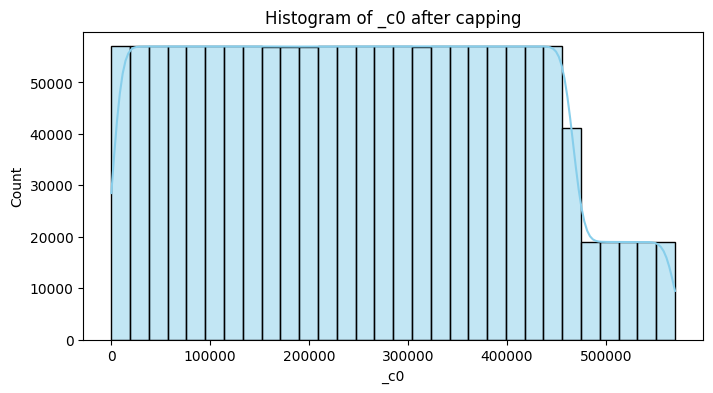

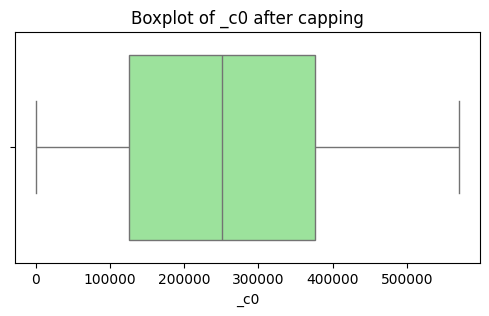

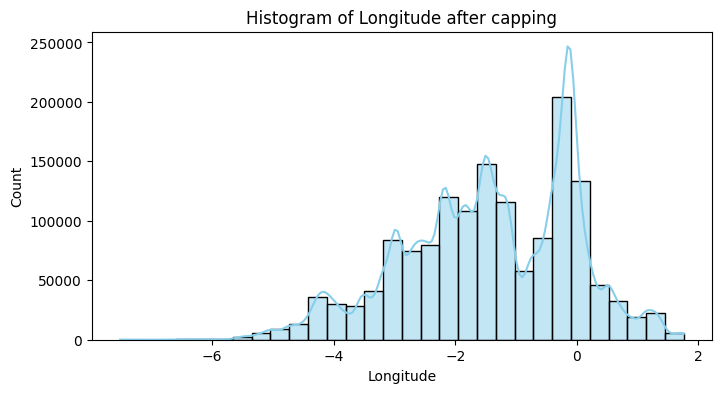

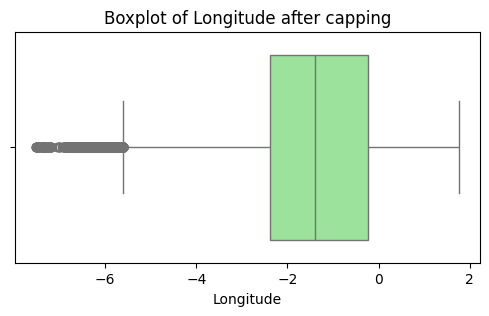

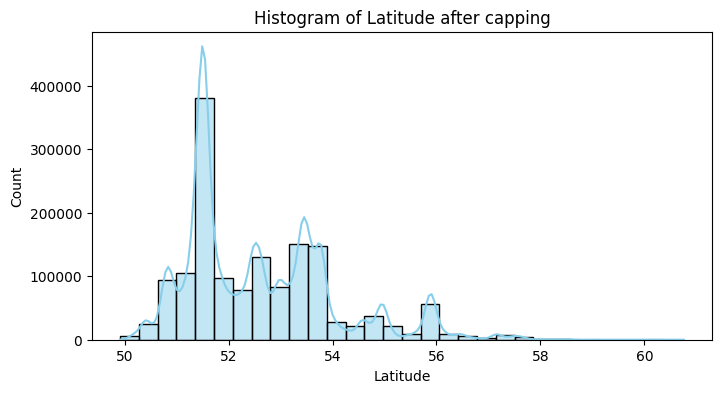

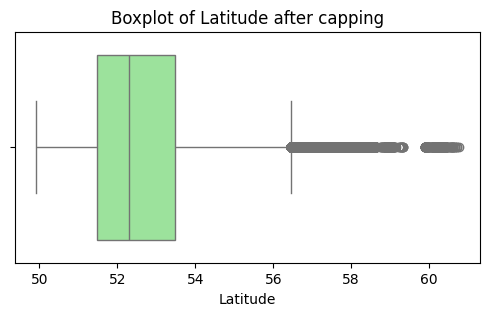

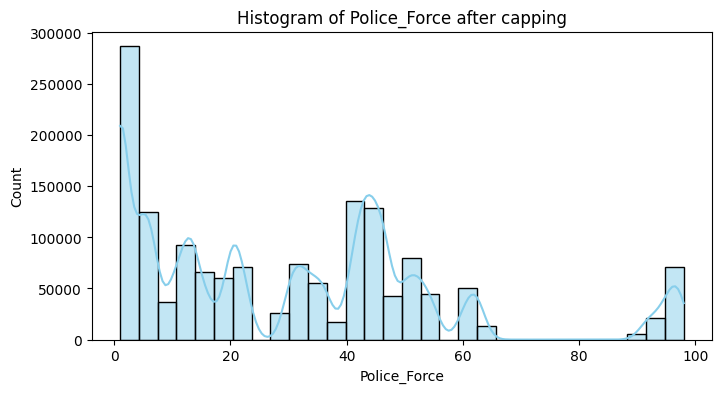

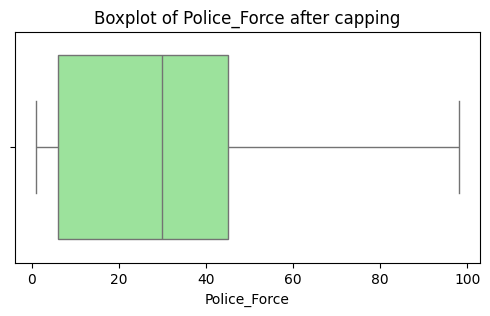

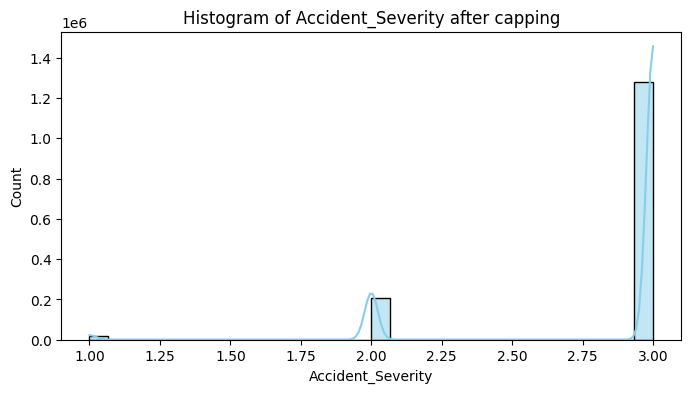

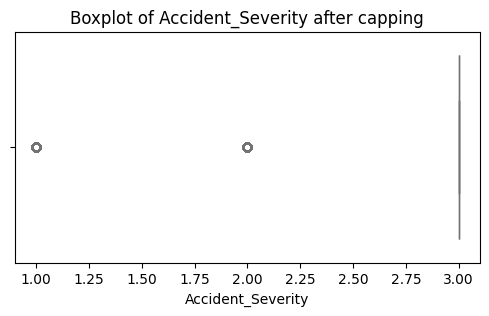

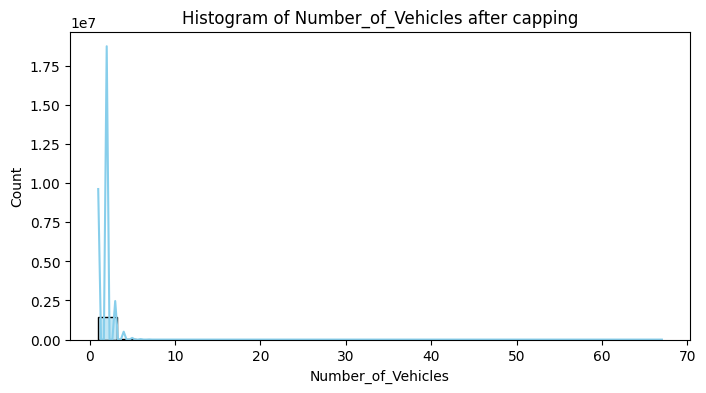

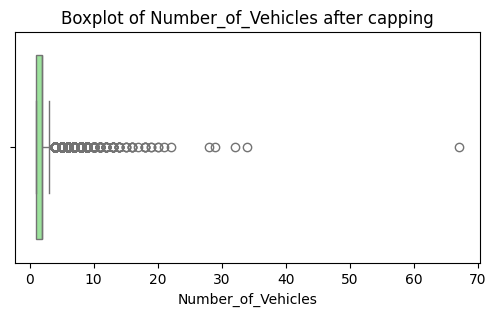

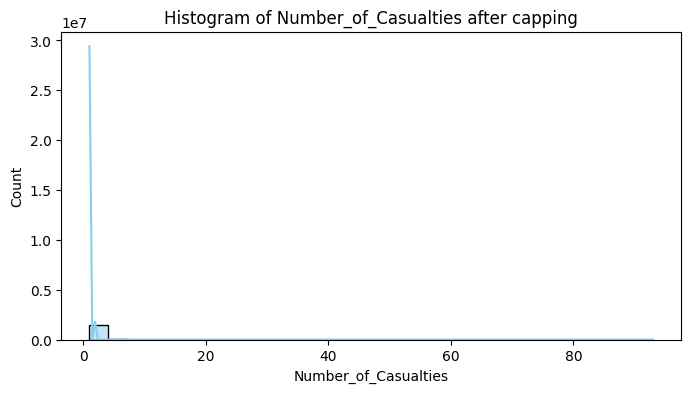

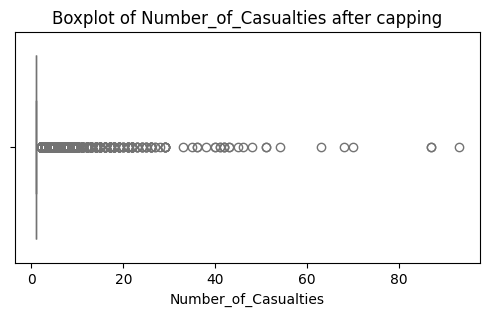

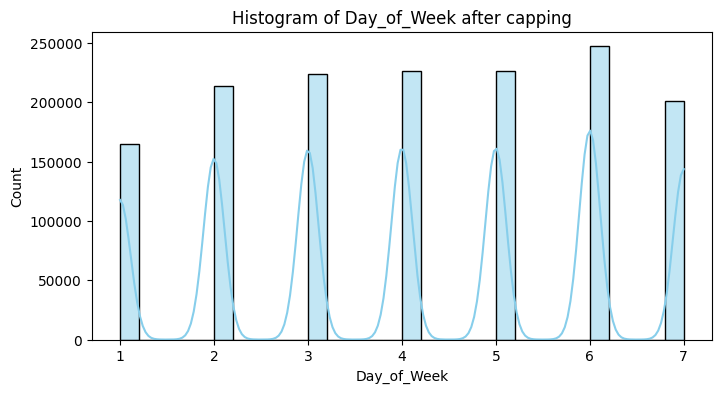

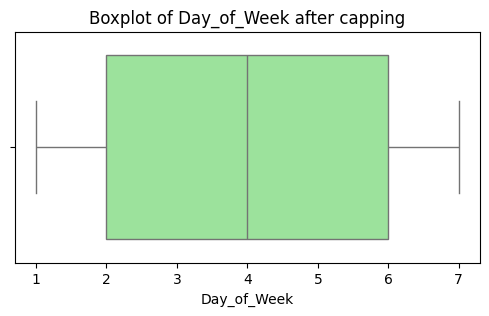

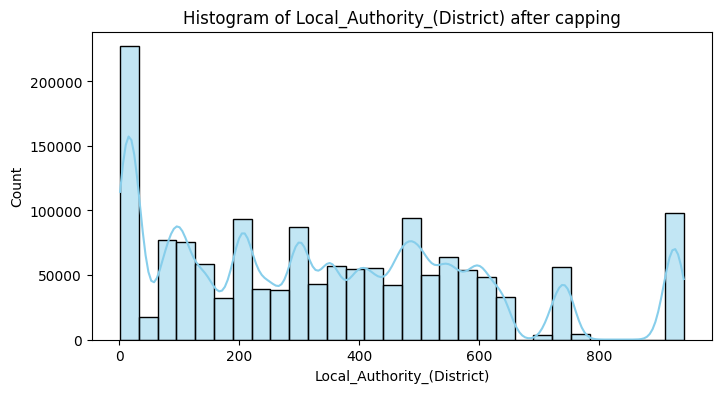

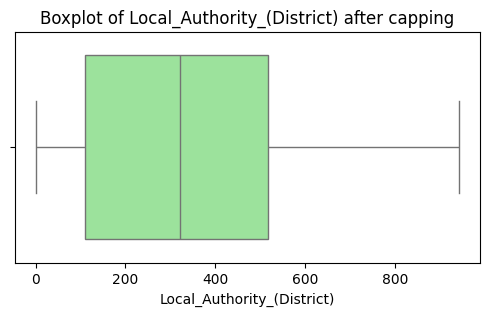

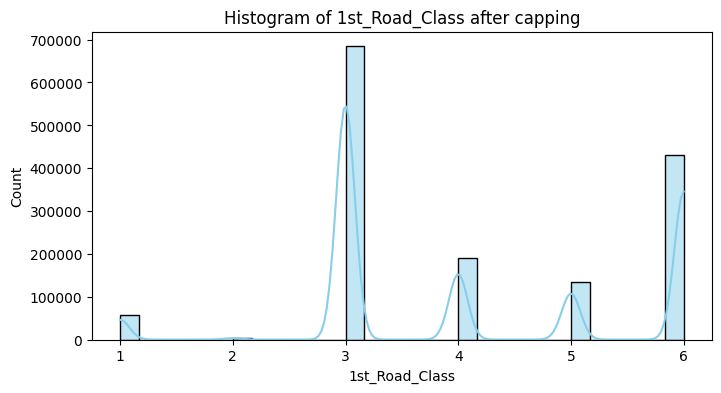

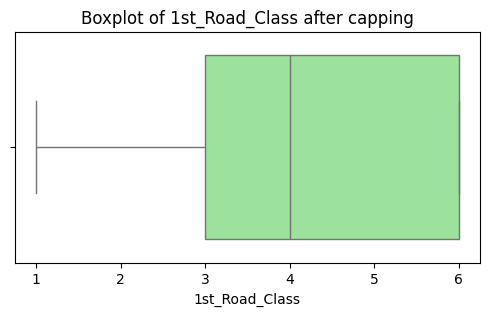

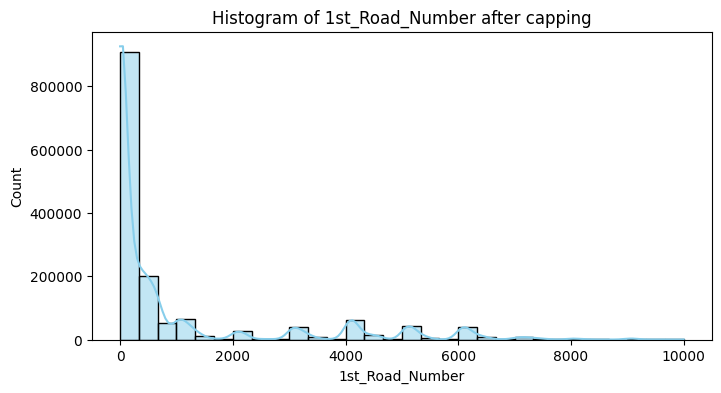

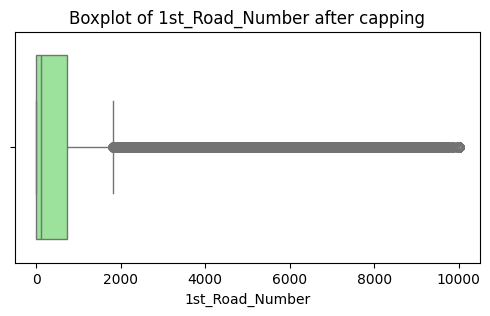

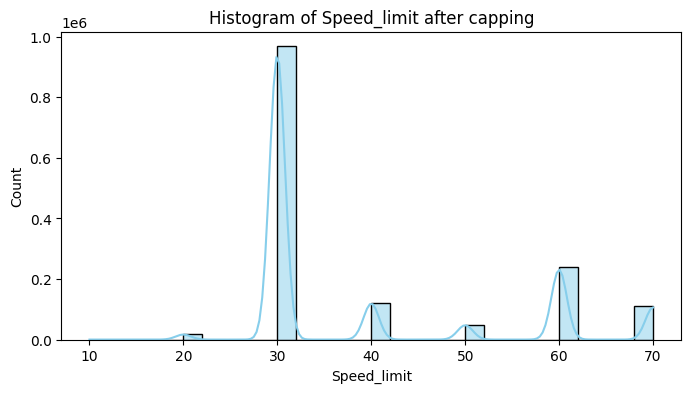

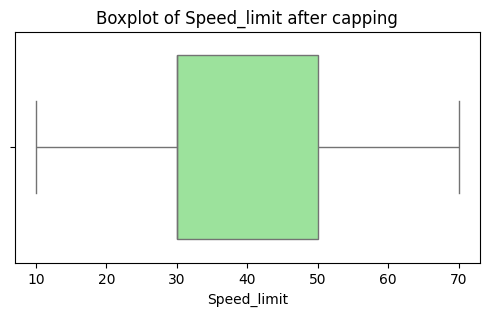

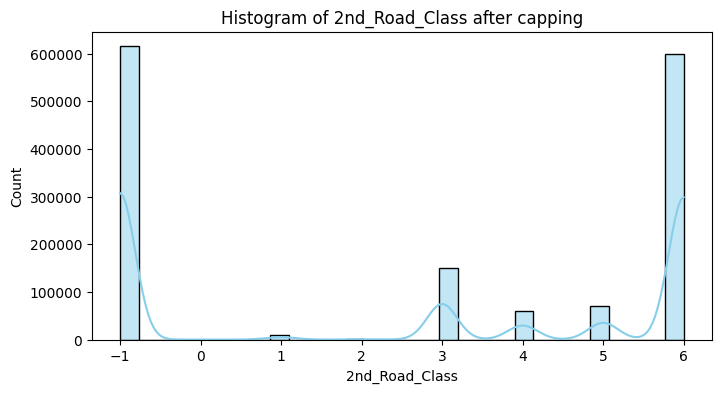

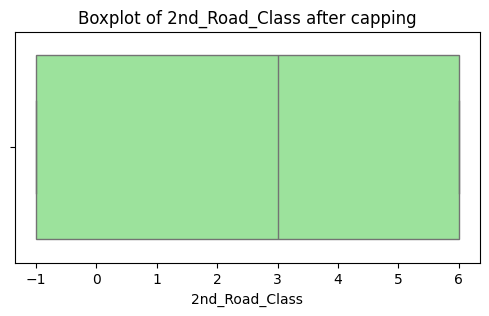

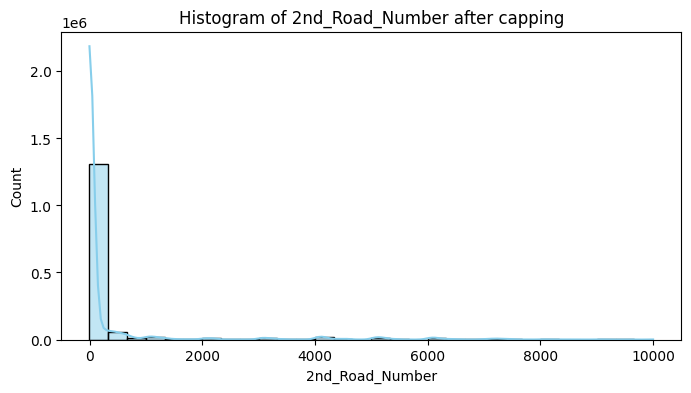

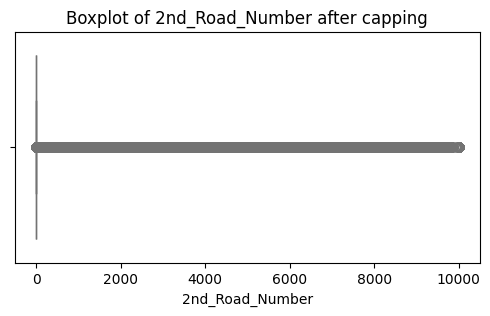

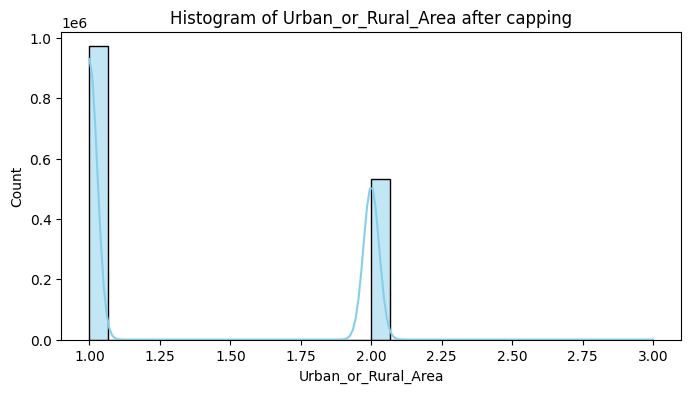

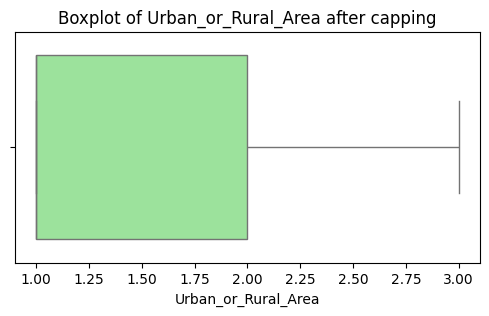

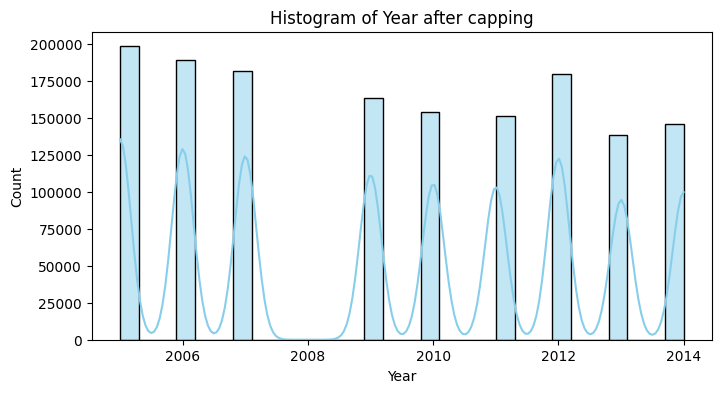

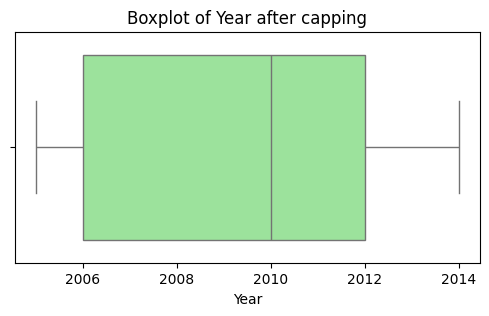

In [ ]:
for c in numeric_cols:
    col_pd = acc.select(c).toPandas()

    plt.figure(figsize=(8,4))
    sns.histplot(col_pd[c], bins=30, kde=True, color='skyblue')
    plt.title(f"Histogram of {c} after capping")
    plt.show()

    plt.figure(figsize=(6,3))
    sns.boxplot(x=col_pd[c], color='lightgreen')
    plt.title(f"Boxplot of {c} after capping")
    plt.show()


## 5. Data Analysis and Implementation

### Preprocessing(Data cleaning and Transformation)

#### Feature engineering

In [ ]:
from pyspark.sql.functions import to_timestamp, dayofmonth, month, year, hour, dayofweek, when

# Use the correct column names
# Date_parsed is your date column, Time_clean is your time column
acc = acc.withColumn("DateTime", to_timestamp("Date_parsed", "dd/MM/yyyy"))
acc = acc.withColumn("Time_parsed", to_timestamp("Time_clean", "HH:mm"))

# Extract day, month, year, hour
acc = acc.withColumn("day", dayofmonth("DateTime")) \
         .withColumn("month", month("DateTime")) \
         .withColumn("year", year("DateTime")) \
         .withColumn("hour", hour("Time_parsed"))

# Day of week
acc = acc.withColumn("day_of_week", dayofweek("DateTime"))

# Weekend flag
acc = acc.withColumn("is_weekend", when(acc.day_of_week.isin([1,7]), 1).otherwise(0))

# Drop original parsed columns if you want
acc = acc.drop("Date_parsed", "Time_clean", "Time_parsed")

# Show to verify
acc.show(5)



+---+--------------+---------+---------+------------+-----------------+------------------+--------------------+----------+-----------+-------------------+--------------------------+-------------------------+--------------+---------------+------------------+-----------+--------------------+--------------+---------------+---------------------------------+---------------------------------------+--------------------+--------------------+-----------------------+--------------------------+-------------------+-------------------+-------------------------------------------+-------------------------+----+-------------------+---+-----+----+----------+
|_c0|Accident_Index|Longitude| Latitude|Police_Force|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|      Date|day_of_week|               Time|Local_Authority_(District)|Local_Authority_(Highway)|1st_Road_Class|1st_Road_Number|         Road_Type|Speed_limit|    Junction_Control|2nd_Road_Class|2nd_Road_Number|Pedestrian_Crossing-Human_Con

#### Encode categorical variables

In [ ]:
categorical_cols = ["Road_Type", "Weather_Conditions", "Light_Conditions",
                    "Junction_Control", "Urban_or_Rural_Area"]


In [ ]:
from pyspark.sql.functions import when

acc = acc.withColumn(
    "time_bin",
    when((acc.hour >= 0) & (acc.hour < 6), "Night")
    .when((acc.hour >= 6) & (acc.hour < 12), "Morning")
    .when((acc.hour >= 12) & (acc.hour < 18), "Afternoon")
    .otherwise("Evening")
)


In [ ]:
from pyspark.ml.feature import StringIndexer

# Add time_bin if created
categorical_cols_with_time = categorical_cols + ["time_bin"]

for col_name in categorical_cols_with_time:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_index")
    acc = indexer.fit(acc).transform(acc)


In [ ]:
acc.select(categorical_cols_with_time + [col + "_index" for col in categorical_cols_with_time]).show(5)


+------------------+--------------------+--------------------+--------------------+-------------------+---------+---------------+------------------------+----------------------+----------------------+-------------------------+--------------+
|         Road_Type|  Weather_Conditions|    Light_Conditions|    Junction_Control|Urban_or_Rural_Area| time_bin|Road_Type_index|Weather_Conditions_index|Light_Conditions_index|Junction_Control_index|Urban_or_Rural_Area_index|time_bin_index|
+------------------+--------------------+--------------------+--------------------+-------------------+---------+---------------+------------------------+----------------------+----------------------+-------------------------+--------------+
|Single carriageway|Raining without h...|Daylight: Street ...|                None|                1.0|Afternoon|            0.0|                     1.0|                   0.0|                   1.0|                      0.0|           0.0|
|  Dual carriageway|Fine without

### check class balance


In [ ]:
# Count the number of records for each accident severity
acc.groupBy("Accident_Severity").count().show()

# Optional: Calculate percentages
total = acc.count()
acc.groupBy("Accident_Severity").count() \
    .withColumn("percentage", (col("count")/total)*100) \
    .show()


+-----------------+-------+
|Accident_Severity|  count|
+-----------------+-------+
|              1.0|  19440|
|              3.0|1280024|
|              2.0| 204468|
+-----------------+-------+

+-----------------+-------+------------------+
|Accident_Severity|  count|        percentage|
+-----------------+-------+------------------+
|              1.0|  19440|1.2926116340366454|
|              3.0|1280024|  85.1118268645125|
|              2.0| 204468|13.595561501450865|
+-----------------+-------+------------------+



### Scaling numeric features


In [ ]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# Select numeric columns to scale
numeric_cols = ["Number_of_Vehicles", "Number_of_Casualties", "Speed_limit", "Longitude", "Latitude", "hour"]

# Assemble into a single vector column
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features")
acc = assembler.transform(acc)

# Apply MinMaxScaler
scaler = MinMaxScaler(inputCol="numeric_features", outputCol="scaled_features")
scaler_model = scaler.fit(acc)
acc = scaler_model.transform(acc)

# Show the scaled features
acc.select("numeric_features", "scaled_features").show(5)


+--------------------+--------------------+
|    numeric_features|     scaled_features|
+--------------------+--------------------+
|[1.0,1.0,30.0,-0....|[0.0,0.0,0.333333...|
|[1.0,1.0,30.0,-0....|[0.0,0.0,0.333333...|
|[2.0,1.0,30.0,-0....|[0.01515151515151...|
|[1.0,1.0,30.0,-0....|[0.0,0.0,0.333333...|
|[1.0,1.0,30.0,-0....|[0.0,0.0,0.333333...|
+--------------------+--------------------+
only showing top 5 rows



### Model building

#### Train /test split

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Assemble all features (numeric + encoded categorical)
feature_cols = ["scaled_features"] + [col + "_index" for col in categorical_cols_with_time]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
acc = assembler.transform(acc)

# Split into train and test sets
train_data, test_data = acc.randomSplit([0.8, 0.2], seed=42)

print("Train Count:", train_data.count())
print("Test Count:", test_data.count())


Train Count: 1203461
Test Count: 300471


In [ ]:
from pyspark.sql.functions import col

# Compute class frequencies
total_count = acc.count()
class_counts = acc.groupBy("Accident_Severity").count().collect()

# Compute weight for each class
weights = {}
for row in class_counts:
    weights[row["Accident_Severity"]] = total_count / (len(class_counts) * row["count"])

print(weights)


{1.0: 25.78758573388203, 3.0: 0.39164161505305106, 2.0: 2.4517805557185803}


#### Random forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Create the model
rf = RandomForestClassifier(
    labelCol="Accident_Severity",
    featuresCol="features",
    weightCol="classWeight"  # You will need to add classWeight column to dataset
)

# Add classWeight column
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

def get_weight(label):
    return float(weights[label])

weight_udf = udf(get_weight, DoubleType())
train_data = train_data.withColumn("classWeight", weight_udf(col("Accident_Severity")))

# Fit model
rf_model = rf.fit(train_data)
predictions = rf_model.transform(test_data)
predictions.select("Accident_Severity", "prediction").show(5)


+-----------------+----------+
|Accident_Severity|prediction|
+-----------------+----------+
|              3.0|       2.0|
|              3.0|       2.0|
|              3.0|       2.0|
|              3.0|       2.0|
|              3.0|       3.0|
+-----------------+----------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="Accident_Severity",
    predictionCol="prediction",
    metricName="f1"
)

f1 = evaluator.evaluate(predictions)
print("F1 Score:", f1)


F1 Score: 0.6193944429591316


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report



In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, classification_report

# Random Forest model
rf = RandomForestClassifier(labelCol="Accident_Severity", featuresCol="features", numTrees=50)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Spark Evaluation
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="Accident_Severity", predictionCol="prediction", metricName="f1")
f1_rf = evaluator_f1.evaluate(rf_predictions)
print("Random Forest - F1 Score:", f1_rf)

evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="Accident_Severity", predictionCol="prediction", metricName="accuracy")
acc_rf = evaluator_acc.evaluate(rf_predictions)
print("Random Forest - Accuracy:", acc_rf)

# Convert to Pandas
y_true = rf_predictions.select("Accident_Severity").toPandas()
y_pred = rf_predictions.select("prediction").toPandas()

# Confusion Matrix & Classification Report
print("Random Forest - Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("Random Forest - Classification Report:")
print(classification_report(y_true, y_pred))


Random Forest - F1 Score: 0.7832945498698182
Random Forest - Accuracy: 0.8515630460177521
Random Forest - Confusion Matrix:
[[     0      0   3933]
 [     0      0  40668]
 [     0      0 255870]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      3933
         2.0       0.00      0.00      0.00     40668
         3.0       0.85      1.00      0.92    255870

    accuracy                           0.85    300471
   macro avg       0.28      0.33      0.31    300471
weighted avg       0.73      0.85      0.78    300471



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, classification_report

# Add classWeight column if not already added
def get_weight(label):
    return float(weights[label])

weight_udf = udf(get_weight, DoubleType())
train_data = train_data.withColumn("classWeight", weight_udf(col("Accident_Severity")))

# Random Forest with class weights
rf = RandomForestClassifier(
    labelCol="Accident_Severity",
    featuresCol="features",
    weightCol="classWeight",
    numTrees=50
)

rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Spark evaluation metrics
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="Accident_Severity", predictionCol="prediction", metricName="f1")
f1_rf = evaluator_f1.evaluate(rf_predictions)

evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="Accident_Severity", predictionCol="prediction", metricName="accuracy")
acc_rf = evaluator_acc.evaluate(rf_predictions)

print("Random Forest - F1 Score:", f1_rf)
print("Random Forest - Accuracy:", acc_rf)

# Convert to Pandas for full classification report
y_true = rf_predictions.select("Accident_Severity").toPandas()
y_pred = rf_predictions.select("prediction").toPandas()

print("Random Forest - Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("Random Forest - Classification Report:")
print(classification_report(y_true, y_pred))


Random Forest - F1 Score: 0.6174105028125311
Random Forest - Accuracy: 0.5191815516306066
Random Forest - Confusion Matrix:
[[  2589    725    619]
 [ 15104  11130  14434]
 [ 66334  47256 142280]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

         1.0       0.03      0.66      0.06      3933
         2.0       0.19      0.27      0.22     40668
         3.0       0.90      0.56      0.69    255870

    accuracy                           0.52    300471
   macro avg       0.37      0.50      0.32    300471
weighted avg       0.80      0.52      0.62    300471



### Decsion tree classifier

In [50]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
from sklearn.metrics import confusion_matrix, classification_report

# Compute class weights (if not already done)
total_count = train_data.count()
class_counts = train_data.groupBy("Accident_Severity").count().collect()
weights = {row["Accident_Severity"]: total_count / (len(class_counts) * row["count"]) for row in class_counts}

# Add classWeight column
def get_weight(label):
    return float(weights[label])
weight_udf = udf(get_weight, DoubleType())
train_data = train_data.withColumn("classWeight", weight_udf(col("Accident_Severity")))

# Create Decision Tree model
dt = DecisionTreeClassifier(
    labelCol="Accident_Severity",
    featuresCol="features",
    weightCol="classWeight"
)

# Fit model
dt_model = dt.fit(train_data)

# Predict on test data
dt_predictions = dt_model.transform(test_data)

# Spark Evaluation
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="Accident_Severity", predictionCol="prediction", metricName="f1")
dt_f1 = evaluator_f1.evaluate(dt_predictions)

evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="Accident_Severity", predictionCol="prediction", metricName="accuracy")
dt_acc = evaluator_acc.evaluate(dt_predictions)

print("Decision Tree - F1 Score:", dt_f1)
print("Decision Tree - Accuracy:", dt_acc)

# Convert to Pandas for detailed metrics
y_true = dt_predictions.select("Accident_Severity").toPandas()
y_pred = dt_predictions.select("prediction").toPandas()

print("Decision Tree - Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("Decision Tree - Classification Report:")
print(classification_report(y_true, y_pred))


Decision Tree - F1 Score: 0.6149187406242574
Decision Tree - Accuracy: 0.5144789347391262
Decision Tree - Confusion Matrix:
[[  2720    555    658]
 [ 16556   9484  14628]
 [ 71778  41710 142382]]
Decision Tree - Classification Report:
              precision    recall  f1-score   support

         1.0       0.03      0.69      0.06      3933
         2.0       0.18      0.23      0.21     40668
         3.0       0.90      0.56      0.69    255870

    accuracy                           0.51    300471
   macro avg       0.37      0.49      0.32    300471
weighted avg       0.79      0.51      0.61    300471

